In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Simulation initial conditions file
Read in the initial conditions as a pandas dataframe

In [2]:
df = pd.read_csv("10000_R3_Plummer.txt",delimiter="\s+")
# Sort by mass
df.sort_values("#Mass_[Msun]",ascending=False,inplace=True)
# Add columns for radius and velocity magnitude
df['r_[pc]']=np.linalg.norm(df[['x_[pc]','y_[pc]','z_[pc]']].values,axis=1)
df['v_[km/s]']=np.linalg.norm(df[["v{}_[km/s]".format(x) for x in 'xyz']].values,axis=1)


# Plummer model
*(Binney & Tremaine, pg. 223-225)*

## DF and density
A Plummer model as an isotropic DF with:
    $$f({\cal E}) = F {\cal E}^{7/2}$$
for ${\cal E}>0$ where 
$$
{\cal E}=\Psi(r)-\frac{1}{2}v^2
$$
The density is given by
$$
\rho(r) = 4\pi F\int_{0}^\sqrt{2\Psi(r)}(\Psi-\frac{1}{2}v^2)^{7/2}v^2dv
$$
and scales with radius as 
$$\rho \propto \frac{1}{(3+(r/b)^2)^{5/2}} $$
where $b$ sets the characteristic scale of the model.


Defining $s = r/b$, the mass enclosed within a given radius is given by: 
$$M_\text{enc}(s)/M_\text{tot} = \frac{s^3}{(3+s^2)^{3/2}}$$
Defining a half-mass radius sets the conversion between $s$ and $r$. Defining $s_{1/2}$ implicitly via the equation:
$$M_\text{enc}(s_{1/2})/M_\text{tot} = \frac{1}{2}$$
gives $s_{1/2}=2.25992$.

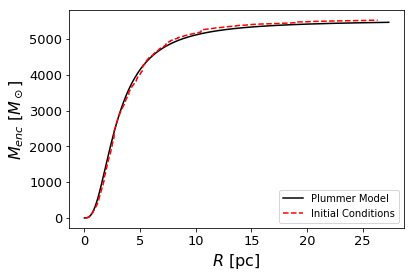

In [3]:
r = df.sort_values('r_[pc]')['r_[pc]'];
msum = df.sort_values('r_[pc]')['#Mass_[Msun]'].cumsum();

s_half = 2.25992
rgrid = np.linspace(0,df['r_[pc]'].max()+1,200)


s = rgrid * (s_half/3)
plt.rcParams["xtick.labelsize"]=13
plt.rcParams["ytick.labelsize"]=13

Mtot = df['#Mass_[Msun]'].sum()
Menc = Mtot *  s*s*s / (3+s*s)**1.5 

plt.plot(rgrid,Menc,'k',label="Plummer Model")
plt.plot(r,msum,'r--',label="Initial Conditions")

plt.xlabel("$R$ [pc]",fontsize=16)
plt.ylabel("$M_{enc}$ [$M_\odot$]",fontsize=16)
plt.legend()

# Some test-particle orbits in Plummer potential

In [4]:
import rebound as rb
import reboundx as rbx
import ctypes

In [5]:
def plummerForce(reb_sim, rebx_effect, particles, N):
    """
    Function for updating particle accelerations due to an external
    Plummer-model potential.
    
    Arguments
    ---------
    reb_sim : rebound Simulation object
        The simulation.
    rebx_effect: reboundx effect
        An insance of a user-defined force in reboundx. Requires
        paramters 'total_mass' and 'half_mass_radius' to define
        the Plummer model potential.
    particles : rebound particles
        The particles that experience the force.
    N : int
        The number of particles.
    
    """
    s_half = 2.25992
    sim = reb_sim.contents
    effect = rebx_effect.contents
    try:
        GMtot = effect.params["total_mass"] * sim.G
    except AttributeError:
        raise RuntimeError("Need to set 'total_mass' parameter for custom plummerForce routine")
    try:
        r_half = effect.params["half_mass_radius"]
    except AttributeError:
        raise RuntimeError("Need to set 'half_mass_radius' parameter for custom plummerForce routine")
    r_to_s = (s_half / r_half)
    ps = sim.particles
    for i in range(N):
        p=ps[i]
        x = p.x
        y = p.y
        z = p.z
        r_sq = x*x+y*y+z*z
        s_sq = r_sq * r_to_s * r_to_s
        Menc_by_Mtot = s_sq**1.5 / np.sqrt(3+s_sq)**3
        p.ax += -GMtot * Menc_by_Mtot * x / r_sq**1.5
        p.ay += -GMtot * Menc_by_Mtot * y / r_sq**1.5
        p.az += -GMtot * Menc_by_Mtot * z / r_sq**1.5



In [6]:
PARSEC_TO_AU = 206265
KMperS_TO_AUperYR = .210805
for coord in 'xyz':
    df['{}'.format(coord)] = df['{}_[pc]'.format(coord)] * PARSEC_TO_AU
    df['v{}'.format(coord)] = df['v{}_[km/s]'.format(coord)] * KMperS_TO_AUperYR



Add 10 random particles to simulation

In [7]:
def get_sim():
    sim = rb.Simulation() 
    sim.units = ['AU', 'yr', 'Msun'] # Set units 
    sim.integrator='leapfrog'
    for _ in range(10):
        row_i = np.random.randint(0,len(df)-1)
        row = df.iloc[row_i]
        sim.add(m=0,
                x=row.x,y=row.y,z=row.z,
                vx=row.vx,vy=row.vy,vz=row.vz
        )
    sim.move_to_com()
    return sim

Set up external force with REBOUNDx

In [8]:
sim = get_sim()
rebx = rbx.Extras(sim)
rebx.register_param('total_mass','REBX_TYPE_DOUBLE')
rebx.register_param('half_mass_radius','REBX_TYPE_DOUBLE')
myforce = rebx.create_force("plummer")
myforce.force_type = 'pos'
try:
    # Load C version of force
    force_lib = ctypes.cdll.LoadLibrary("/Users/shadden/DropboxSmithsonian/Papers/14_BBH/01_code/libforces.so")
    myforce.update_accelerations = force_lib.rebx_plummer_potential
    print("Loading C version of force...")
except:
    # Use Python version
    myforce.update_accelerations = plummerForce
    print("Using Python version of force...")
rebx.add_force(myforce)
myforce.params['total_mass']= df["#Mass_[Msun]"].sum()
myforce.params['half_mass_radius']= 3 * PARSEC_TO_AU

Loading C version of force...


Set time-step

In [9]:
Tcross = myforce.params['half_mass_radius'] / np.sqrt(2*sim.G * myforce.params['total_mass'] /  myforce.params['half_mass_radius'])
sim.dt=Tcross/100

Integrate particles, save orbits

In [10]:
ps=sim.particles
times = np.linspace(0,200*Tcross,256)
x,y,z = np.zeros((3,len(ps),len(times)))
for i,t in enumerate(times):
    sim.integrate(t)
    for j,p in enumerate(ps):
        x[j,i]=p.x
        y[j,i]=p.y        
        z[j,i]=p.z

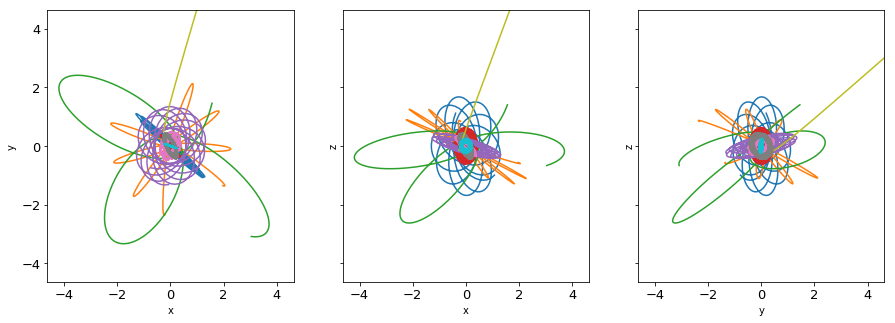

In [11]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
box_size=1.5*np.max(np.append(np.append(np.abs(x[:,0]),np.abs(y[:,0])),np.abs(z[:,0])))
for i in range(len(ps)):
    ax[0].plot(x[i]/1e6,y[i]/1e6)
    ax[1].plot(x[i]/1e6,z[i]/1e6)
    ax[2].plot(y[i]/1e6,z[i]/1e6)
    
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].set_xlabel('x')
ax[1].set_ylabel('z')

ax[2].set_xlabel('y')
ax[2].set_ylabel('z')


for i in range(3):
    ax[i].set_xlim(-box_size/1e6,box_size/1e6)
    ax[i].set_ylim(-box_size/1e6,box_size/1e6)

# Simulation archiving

In [12]:
sim = get_sim()
rebx = rbx.Extras(sim)
rebx.register_param('total_mass','REBX_TYPE_DOUBLE')
rebx.register_param('half_mass_radius','REBX_TYPE_DOUBLE')
myforce = rebx.create_force("plummer")
myforce.force_type = 'pos'
try:
    # Load C version of force
    force_lib = ctypes.cdll.LoadLibrary("/Users/shadden/DropboxSmithsonian/Papers/14_BBH/01_code/libforces.so")
    myforce.update_accelerations = force_lib.rebx_plummer_potential
    print("Loading C version of force...")
except:
    # Use Python version
    myforce.update_accelerations = plummerForce
    print("Using Python version of force...")
rebx.add_force(myforce)
myforce.params['total_mass']= df["#Mass_[Msun]"].sum()
myforce.params['half_mass_radius']= 3 * PARSEC_TO_AU
Tcross = myforce.params['half_mass_radius'] / np.sqrt(2*sim.G * myforce.params['total_mass'] /  myforce.params['half_mass_radius'])
sim.dt=Tcross/100

Loading C version of force...


In [13]:
rebx.save("rebxpars.bin")
sim.automateSimulationArchive('sim_archive.bin',interval= 0.25 * Tcross,deletefile=True)
sim.integrate(300 * Tcross)
del sim
sa = rb.SimulationArchive("sim_archive.bin",rebxfilename = "rebxpars.bin")

In [14]:
sa[0]

AttributeError: type object 'Extras' has no attribute 'from_file'

In [ ]:

x,y,z = np.zeros((3,len(ps),len(sa)))
for i,sim in enumerate(sa):
    ps=sim.particles
    for j,p in enumerate(ps):
        x[j,i]=p.x
        y[j,i]=p.y        
        z[j,i]=p.z

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
box_size=1.5*np.max(np.append(np.append(np.abs(x[:,0]),np.abs(y[:,0])),np.abs(z[:,0])))
for i in range(len(ps)):
    ax[0].plot(x[i]/1e6,y[i]/1e6)
    ax[1].plot(x[i]/1e6,z[i]/1e6)
    ax[2].plot(y[i]/1e6,z[i]/1e6)
    
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].set_xlabel('x')
ax[1].set_ylabel('z')

ax[2].set_xlabel('y')
ax[2].set_ylabel('z')


for i in range(3):
    ax[i].set_xlim(-box_size/1e6,box_size/1e6)
    ax[i].set_ylim(-box_size/1e6,box_size/1e6)